In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')


## READING MATERIAL

```
1. https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e

2. https://www.sartorius.com/en/knowledge/science-snippets/what-is-principal-component-analysis-pca-and-how-it-is-used-507186
```


## LOADING IRIS DATASET


In [3]:
# Load the data
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Z-score the features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


## FITTING THE PCA MODEL


$X = TP^T + E$  

where,  
X = data ($R*C$)  
T = scores ($R*components$)  
$P^T$ = Loadings ($compnents*C$), a.k.a features  
E = Residuals


In [4]:
pca = PCA(n_components=2) # estimate only 2 PCs


## SCORE MATIX


In [5]:
X_new = pca.fit_transform(X) # Scores. Project the original data into the PCA space


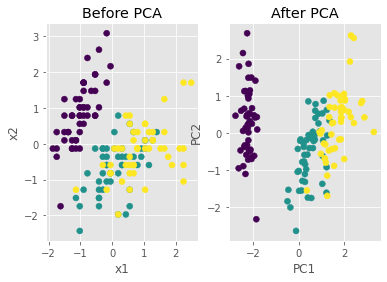

In [6]:
fig, axes = plt.subplots(1,2)
axes[0].scatter(X[:,0], X[:,1], c=y)
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Before PCA')
axes[1].scatter(X_new[:,0], X_new[:,1], c=y)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('After PCA')
plt.show()


In [7]:
## PCA SPACE EXPLAINED VARIANCE
print(pca.explained_variance_ratio_)


[0.72962445 0.22850762]


## FEATURE IMPORTANCE
aka **LOADING MATRIX**


In [8]:
imp_df = pd.DataFrame(pca.components_, columns=iris.feature_names, index=["pca1", "pca2"])
imp_df


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
pca1,0.521066,-0.269347,0.580413,0.564857
pca2,0.377418,0.923296,0.024492,0.066942


## BI PLOT
PLOT **LOADING MATRIX** & **SCORE MATRIX** ON A SINGLE PLOT


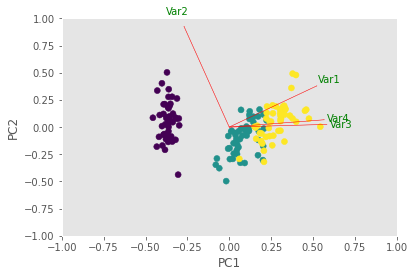

In [9]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2)) 
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(X_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()


## TOTAL VARIANCE
$\sum X^2 = \sum PC_{1}^2  +  \sum PC_{2}^2 + \sum \epsilon^2$  

where,  
$
\sum X^2 = 600 \\  
\sum PC_{1}^2  = 437.77 \\
\sum PC_{2}^2  = 137.1 \\
\sum \epsilon^2 = 25.13
$


## EXPLAINED VARIANCE
## PC1:


$\frac{\sum PC_{1}^2}{\sum X^2} = \frac{600}{437.7} = 0.73$ 

MATCHING WITH THE **SKLEARN EXPLAINED VARIANCE** ALSO


### CALCULATING AND MATCHING EXPLAINED VARIANCE WITH SKLEARN OUTPUT


In [10]:
print("SKLEARN EXPLAINED VARIANCE:", list(map(lambda x: round(x, 2), pca.explained_variance_ratio_)))


SKLEARN EXPLAINED VARIANCE: [0.73, 0.23]


CALCULATING: $\sum X^2$


In [11]:
X_sum = np.sum(X**2)
print(round(X_sum,2))


600.0


$\sum PC_{1}^2$ = 437.77  
$\sum PC_{2}^2$ = 137.1  
$\sum \epsilon^2$  = 25


In [12]:
# PC = np.dot(score, loading matix)
for i in range(2):
    score_matrix = X_new[:,i].reshape(-1,1)
    loading_matrix = pca.components_[i,:].reshape(1,-1)
    print(i+1, round(np.sum((np.dot(score_matrix, loading_matrix))**2), 2))



1 437.77
2 137.1


# SELECTING THE OPTIMAL NUMBER OF COMPONENTS PCA


### MATERIAL
```
https://www.youtube.com/watch?v=ZTqE6JkAb20&list=PLBC24FD8C389FE9E4&index=6&ab_channel=Chemometrics%26MachineLearninginCopenhagen
```

In [13]:
cancer_data = datasets.load_breast_cancer()

X = cancer_data.data
y = cancer_data.target
feature_names = cancer_data.feature_names

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


### EXPLAINED VARIANCE BY FITTING PCA ON ALL THE DATA


In [14]:
explained_var_all = {}
for i in range(1, 12):
    pca_model = PCA(n_components=i).fit(X)
    
    explained_var_all[i] = [sum(pca_model.explained_variance_ratio_)]


### MEAN CROSS VALIDATION EXPLAINED VARIANCE


In [15]:
explained_var_cv = {}
for i in range(1, 12):
    
    left_index=0
    pca_exp_list = []
    for n in range(50, len(X), 50):
        cv_data = X[left_index:n]
        train_data = np.vstack((X[:left_index], X[n:]))
        pca_model = PCA(n_components=i).fit(train_data)

        score_matrix = pca_model.transform(cv_data)
        loading_matrix = pca_model.components_.reshape(i,-1)
        cv_pca_var = np.sum(np.dot(score_matrix, loading_matrix) ** 2)
        cv_data_var = np.sum(cv_data ** 2)
        
        cv_exp_var = cv_pca_var/cv_data_var        
        pca_exp_list.append(cv_exp_var)

        left_index = n
#         import sys; sys.exit(1)

    explained_var_cv[i] = [np.mean(pca_exp_list)]
    


## OUTLIER DETECTION


### MATERIAL
```
1. https://www.youtube.com/watch?v=ExoAbXPJ7NQ&list=PLBC24FD8C389FE9E4&index=6&ab_channel=Chemometrics%26MachineLearninginCopenhagen
2. https://www.youtube.com/watch?v=xj2cWnI2ih8&list=PLBC24FD8C389FE9E4&index=7&ab_channel=Chemometrics%26MachineLearninginCopenhagen
```


In [16]:
import subprocess
_= subprocess.check_output("pip install pca", shell=True)


In [17]:
from pca import pca
import pandas as pd
import numpy as np

# Initialize model. Alpha is the threshold for the hotellings T2 test to determine outliers in the data.
model = pca(alpha=0.05)

# Fit transform
out = model.fit_transform(X)


[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [30] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[10]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


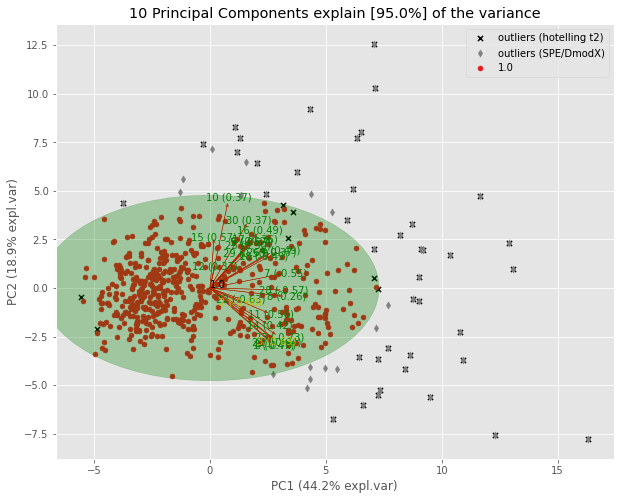

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'10 Principal Components explain [95.0%] of the variance'}, xlabel='PC1 (44.2% expl.var)', ylabel='PC2 (18.9% expl.var)'>)

In [18]:
model.biplot(legend=True, SPE=True, hotellingt2=True)
